# Spark eda

In this demo, we will use spark to do EDA (Exploratory Data Analysis) on all 911 calls of san francisco of the last 10 year

In [22]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col

from pyspark.sql.types import IntegerType
import numpy as np # linear algebra
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [3]:
local=False
if local:
    spark=SparkSession.builder.master("local[4]") \
                  .appName("spark_eda").getOrCreate()
else:
    spark=SparkSession.builder \
                      .master("k8s://https://kubernetes.default.svc:443") \
                      .appName("spark_data_eda") \
                      .config("spark.kubernetes.container.image",os.environ["IMAGE_NAME"]) \
                      .config("spark.kubernetes.authenticate.driver.serviceAccountName",os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
                      .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
                      .config("spark.executor.instances", "4") \
                      .config("spark.executor.memory","2g") \
                      .config("spark.driver.memory","2g") \
                      .enableHiveSupport() \
                      .getOrCreate()

2022-10-26 12:05:31,697 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-10-26 12:05:32,095 INFO spark.SparkContext: Running Spark version 3.3.0
2022-10-26 12:05:32,161 INFO resource.ResourceUtils: ==============================================================
2022-10-26 12:05:32,162 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2022-10-26 12:05:32,162 INFO resource.ResourceUtils: ==============================================================
2022-10-26 12:05:32,163 INFO spark.SparkContext: Submitted application: spark_data_eda
2022-10-26 12:05:32,184 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 2048, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2022-10-26 12:

In [8]:
def set_log_level(spark_session,log_level:str):
    logger = spark_session.sparkContext._jvm.org.apache.log4j
    if log_level=="INFO":
        logger_level = logger.Level.INFO
    elif log_level=="WARN":
        logger_level = logger.Level.WARN
    elif log_level=="ERROR":
        logger_level = logger.Level.ERROR
    else:
        raise ValueError("The log_level must be INFO, WARN or ERROR")
    logger.LogManager.getLogger("org").setLevel(logger_level)
    logger.LogManager.getLogger("akka").setLevel(logger_level)
    
set_log_level(spark,"ERROR")

## Check worker number

### Check the worker number via Spark UI

To check how many workers with gpu has been deoployed. You can use the spark UI to view the status of all the workers.

### Check the worker number via kubectl
You can also use below command to check your spark worker number

In [9]:
! kubectl get pods -l spark-role=executor

NAME                                     READY   STATUS    RESTARTS   AGE
spark-data-eda-b1280284142ef788-exec-2   1/1     Running   0          2m37s


## Do some analysis

In [5]:
work_dir="s3a://pengfei"
parquet_file_name="onyxia_demo/sf_fire"
data_path=f"{work_dir}/{parquet_file_name}"

In [10]:
df_raw=spark.read.parquet(data_path)

In [11]:
row_nb=df_raw.count()
col_nb=len(df_raw.columns)

print(f"data frame has : {row_nb} rows and {col_nb} columns")

data frame has : 5500519 rows and 34 columns


In [12]:
df_raw.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- ReceivedDtTm: string (nullable = true)
 |-- EntryDtTm: string (nullable = true)
 |-- DispatchDtTm: string (nullable = true)
 |-- ResponseDtTm: string (nullable = true)
 |-- OnSceneDtTm: string (nullable = true)
 |-- TransportDtTm: string (nullable = true)
 |-- HospitalDtTm: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- ZipcodeofIncident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPr

In [15]:
df_raw.show(5)

+----------+------+--------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+-------------+-----------------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+--------+--------------------------+----------------------+------------------+--------------------+-------------+--------------------+
|CallNumber|UnitID|IncidentNumber|            CallType|  CallDate| WatchDate|        ReceivedDtTm|           EntryDtTm|        DispatchDtTm|        ResponseDtTm|         OnSceneDtTm|TransportDtTm|HospitalDtTm|CallFinalDisposition|       AvailableDtTm|             Address|         City|ZipcodeofIncident|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumberofAlarms|UnitType|Unitsequenceincalldispatch|FirePreventio

## Q1 How many distinct types of calls were made to the Fire Department?



In [27]:
all_call_type=df_raw.select("CallType").filter(col("CallType").isNotNull()).distinct()

all_call_type.show(truncate=False)

+--------------------------------------------+
|CallType                                    |
+--------------------------------------------+
|Marine Fire                                 |
|Elevator / Escalator Rescue                 |
|Aircraft Emergency                          |
|Confined Space / Structure Collapse         |
|Administrative                              |
|Alarms                                      |
|Odor (Strange / Unknown)                    |
|Lightning Strike (Investigation)            |
|Citizen Assist / Service Call               |
|HazMat                                      |
|Watercraft in Distress                      |
|Explosion                                   |
|Oil Spill                                   |
|Vehicle Fire                                |
|Suspicious Package                          |
|Extrication / Entrapped (Machinery, Vehicle)|
|Other                                       |
|Outside Fire                                |
|Traffic Coll

In [28]:
total_num=all_call_type.count()

print(f"The total number of distinct call types are: {total_num}")

The total number of distinct call types are: 32


## Q2 What is the top 10 call type of San Francisco 911 service?

In [29]:
top10CallType=df_raw.groupBy("CallType").agg(count("IncidentNumber").alias("incident_number")).orderBy(col("incident_number").desc()).limit(10)
top10CallType.show(20,truncate=False)

+-------------------------------+---------------+
|CallType                       |incident_number|
+-------------------------------+---------------+
|Medical Incident               |3596332        |
|Structure Fire                 |681179         |
|Alarms                         |599263         |
|Traffic Collision              |224909         |
|Other                          |87468          |
|Citizen Assist / Service Call  |82173          |
|Outside Fire                   |68491          |
|Water Rescue                   |28253          |
|Vehicle Fire                   |25512          |
|Gas Leak (Natural and LP Gases)|22961          |
+-------------------------------+---------------+



In [30]:
callPdf=top10CallType.toPandas()

call=callPdf['CallType'].tolist()
incident_count=callPdf['incident_number'].tolist()

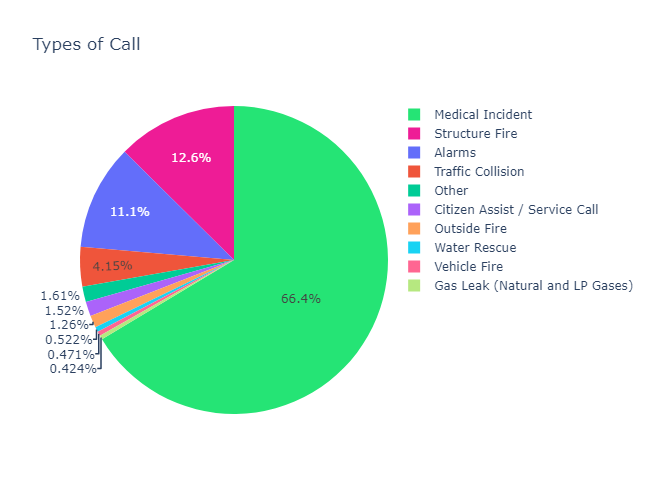

In [31]:
pie_visual = go.Pie(labels=call, values=incident_count, marker=dict(colors=['#25e475', '#ee1c96',]))

layout = go.Layout(title='Types of Call', width=800, height=500)
fig = go.Figure(data=[pie_visual], layout=layout)
iplot(fig)

## Q3 Find out all response or delayed times greater than 5 mins?

1. Rename the column Delay - > ReponseDelayedinMins
2. Returns a new DataFrame
3. Find out all calls where the response time to the fire site was delayed for more than 5 mins

We don't have a column `Delay`, so we need to use 
- ReceivedDtTm
- EntryDtTm
- DispatchDtTm
- ResponseDtTm
- OnSceneDtTm

In [35]:
df_raw.select("IncidentNumber","ReceivedDtTm","EntryDtTm","DispatchDtTm","ResponseDtTm","OnSceneDtTm").show(2,truncate=False)

+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|IncidentNumber|ReceivedDtTm          |EntryDtTm             |DispatchDtTm          |ResponseDtTm          |OnSceneDtTm           |
+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|21017645      |02/08/2021 01:00:14 PM|02/08/2021 01:01:36 PM|02/08/2021 01:01:40 PM|02/08/2021 01:03:21 PM|02/08/2021 01:05:44 PM|
|21017596      |02/08/2021 10:54:56 AM|02/08/2021 10:56:50 AM|02/08/2021 10:56:57 AM|02/08/2021 10:57:07 AM|02/08/2021 10:59:34 AM|
+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
only showing top 2 rows



We could use `OnSeneDTTm-ReceivedDtTm` to evaluate the deplay between a call received by the fire departement and fire fighter on scene. The problem here is

In [33]:
fire_df1=df_raw.withColumnRenamed("Delay","ResponseDelayedinMins")

In [34]:
delayed_response=fire_df1.filter(col("ResponseDelayedinMins")>5)
delayed_response.show()

AnalysisException: Column 'ResponseDelayedinMins' does not exist. Did you mean one of the following? [ResponseDtTm, ReceivedDtTm, FinalPriority, Location, OriginalPriority, ZipcodeofIncident, Battalion, CallDate, CallFinalDisposition, DispatchDtTm, HospitalDtTm, NumberofAlarms, OnSceneDtTm, RowID, StationArea, SupervisorDistrict, WatchDate, ALSUnit, Address, AvailableDtTm, CallType, CallTypeGroup, EntryDtTm, FirePreventionDistrict, IncidentNumber, NeighborhoodDistrict, Priority, TransportDtTm, UnitID, UnitType, Box, CallNumber, City, Unitsequenceincalldispatch];
'Filter ('ResponseDelayedinMins > 5)
+- Relation [CallNumber#68,UnitID#69,IncidentNumber#70,CallType#71,CallDate#72,WatchDate#73,ReceivedDtTm#74,EntryDtTm#75,DispatchDtTm#76,ResponseDtTm#77,OnSceneDtTm#78,TransportDtTm#79,HospitalDtTm#80,CallFinalDisposition#81,AvailableDtTm#82,Address#83,City#84,ZipcodeofIncident#85,Battalion#86,StationArea#87,Box#88,OriginalPriority#89,Priority#90,FinalPriority#91,... 10 more fields] parquet
